In [139]:
import pickle
import sklearn
import modAL
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from modAL.uncertainty import uncertainty_sampling
import sys


import audio_decryption
import IPython.display

# 1. Read negative file into test and train #

In [158]:
neg_file= open("/home/amm1209/sonyc_distortion_classification/data/negative_xy_new.pickle", "rb")
negative_xy = pickle.load(neg_file)

In [159]:
negative_xy

array([['146', '14', '129', ..., '255', '0', 'b827eb4e7821'],
       ['154', '30', '171', ..., '255', '0', 'b827eb4e7821'],
       ['153', '25', '150', ..., '255', '0', 'b827eb4e7821'],
       ...,
       ['153', '25', '146', ..., '255', '0', 'b827eb9bed23'],
       ['153', '25', '152', ..., '255', '0', 'b827eb9bed23'],
       ['155', '23', '168', ..., '255', '0', 'b827eb429cd4']],
      dtype='<U21')

In [160]:
sens= []
for i in range(negative_xy.shape[0]):
    sens.append(negative_xy[i,-1])

In [161]:
unique_sensors = np.unique(sens)

In [162]:
unique_sensors

array(['b827eb0d8af7', 'b827eb0fedda', 'b827eb122f0f', 'b827eb1685c7',
       'b827eb2a1bce', 'b827eb429cd4', 'b827eb42bd4a', 'b827eb44506f',
       'b827eb4e7821', 'b827eb5895e9', 'b827eb815321', 'b827eb86d458',
       'b827eb8e2420', 'b827eb9bed23', 'b827ebad073b'], dtype='<U12')

In [163]:
negative_test = np.zeros((7*20,negative_xy.shape[1]-1))
negative_train = np.zeros((8*20,negative_xy.shape[1]-1))
j=0
k=0
for i in range(negative_xy.shape[0]):
    
    if negative_xy[i,-1]=='b827eb0d8af7' or negative_xy[i,-1]=='b827eb0fedda' or negative_xy[i,-1]=='b827eb122f0f' or negative_xy[i,-1]=='b827eb1685c7' or negative_xy[i,-1]=='b827eb2a1bce'or negative_xy[i,-1]=='b827eb429cd4' or negative_xy[i,-1]=='b827eb42bd4a':
        negative_test[j,:]= negative_xy[i,:-1]
        j=j+1
    else:
        negative_train[k,:]= negative_xy[i,:-1]
        k=k+1 

In [164]:
negative_train = negative_train.astype(int)

In [165]:
negative_train

array([[146,  14, 129, ...,  62, 255,   0],
       [154,  30, 171, ..., 158, 255,   0],
       [153,  25, 150, ..., 150, 255,   0],
       ...,
       [158,  29, 166, ...,  87, 255,   0],
       [153,  25, 146, ...,   0, 255,   0],
       [153,  25, 152, ...,   0, 255,   0]])

In [166]:
negative_test = negative_test.astype(int)

In [167]:
negative_test

array([[152,  24, 142, ...,  30, 255,   0],
       [162,  34, 157, ..., 255, 255,   0],
       [154,  28, 152, ..., 129, 255,   0],
       ...,
       [156,  25, 180, ...,   7, 255,   0],
       [153,  28, 170, ..., 124, 255,   0],
       [155,  23, 168, ...,  90, 255,   0]])

# 2. Read positive file into test and train #

In [168]:
positive_xy = pickle.load(open( "/home/amm1209/sonyc_distortion_classification/data/positive_xy_new.pickle", "rb" ))

In [169]:
positive_xy

array([['153', '17', '128', ..., '255', '1', 'b827eb429cd4'],
       ['150', '19', '127', ..., '255', '1', 'b827eb429cd4'],
       ['155', '18', '126', ..., '255', '1', 'b827eb429cd4'],
       ...,
       ['160', '20', '161', ..., '255', '1', 'b827eb42bd4a'],
       ['154', '20', '139', ..., '255', '1', 'b827eb42bd4a'],
       ['154', '21', '130', ..., '255', '1', 'b827eb42bd4a']],
      dtype='<U21')

In [170]:
positive_test = np.zeros((7*20,positive_xy.shape[1]-1))
positive_train = np.zeros((8*20,positive_xy.shape[1]-1))
j=0
k=0
for i in range(positive_xy.shape[0]):
    
    if positive_xy[i,-1]=='b827eb0d8af7' or positive_xy[i,-1]=='b827eb0fedda' or positive_xy[i,-1]=='b827eb122f0f' or positive_xy[i,-1]=='b827eb1685c7' or positive_xy[i,-1]=='b827eb2a1bce'or positive_xy[i,-1]=='b827eb429cd4' or positive_xy[i,-1]=='b827eb42bd4a':
        positive_test[j,:]= positive_xy[i,:-1]
        j=j+1
    else:
        positive_train[k,:]= positive_xy[i,:-1]
        k=k+1 

In [171]:
positive_train = positive_train.astype(int)

In [172]:
positive_train

array([[152,   7, 152, ..., 200, 255,   1],
       [151,  12, 155, ...,  87, 255,   1],
       [155,  17, 160, ...,   0, 255,   1],
       ...,
       [153,  22, 143, ..., 202, 255,   1],
       [157,  14, 162, ..., 163, 255,   1],
       [152,  21, 140, ..., 243, 255,   1]])

In [173]:
positive_test = positive_test.astype(int)

In [174]:
positive_test

array([[153,  17, 128, ..., 136, 255,   1],
       [150,  19, 127, ...,  76, 255,   1],
       [155,  18, 126, ..., 156, 255,   1],
       ...,
       [160,  20, 161, ..., 167, 255,   1],
       [154,  20, 139, ..., 255, 255,   1],
       [154,  21, 130, ..., 137, 255,   1]])

# 3. Concatenate negatives and positives in both test and train #

## 3.1. Concatenate train examples together ##

In [175]:
train = np.concatenate((positive_train, negative_train))

In [178]:
train

array([[152,   7, 152, ..., 200, 255,   1],
       [151,  12, 155, ...,  87, 255,   1],
       [155,  17, 160, ...,   0, 255,   1],
       ...,
       [158,  29, 166, ...,  87, 255,   0],
       [153,  25, 146, ...,   0, 255,   0],
       [153,  25, 152, ...,   0, 255,   0]])

## 3.2. Concatenate test examples together ##

In [179]:
test = np.concatenate((positive_test, negative_test))

In [180]:
test

array([[153,  17, 128, ..., 136, 255,   1],
       [150,  19, 127, ...,  76, 255,   1],
       [155,  18, 126, ..., 156, 255,   1],
       ...,
       [156,  25, 180, ...,   7, 255,   0],
       [153,  28, 170, ..., 124, 255,   0],
       [155,  23, 168, ...,  90, 255,   0]])

## 3.3. Shuffle data ##

In [181]:
np.random.shuffle(train)

In [182]:
np.random.shuffle(test)

## 3.4. Separate x and y ##

### 3.4.1. Separate training data ###

In [183]:
x_train = train[:,:-1]

In [184]:
x_train.shape

(320, 128)

In [185]:
y_train = train[:,-1]

In [186]:
y_train.shape

(320,)

### 3.4.2. Separate test data ###

In [187]:
x_test = test[:,:-1]

In [188]:
x_test.shape

(280, 128)

In [189]:
y_test = test[:,-1]

In [190]:
y_test.shape

(280,)

# 4. Read X_pool file #

In [191]:
pool_file= open("/home/amm1209/sonyc_distortion_classification/data/X_pool_10000.pickle", "rb")
X_pool = pickle.load(pool_file)

In [192]:
X_pool.shape

(9974, 128)

In [193]:
ids_file= open("/home/amm1209/sonyc_distortion_classification/data/id_pool_10000.pickle", "rb")
id_pool = pickle.load(ids_file)

In [194]:
id_pool.shape

(9974, 2)

In [195]:
sensor_id = []
time_stamp = []
frame = []
for i in range(len(id_pool)):
    sensor_timestamp = id_pool[i][0]
    if len(sensor_timestamp.decode("utf-8").split('_')) ==1:
        print(sensor_timestamp)
        sensor_id.append(sensor_timestamp.decode("utf-8").split('-')[0])
        time_stamp.append(float(sensor_timestamp.decode("utf-8").split('-')[1]))
    else:     
        sensor_id.append(sensor_timestamp.decode("utf-8").split('_')[0])
        time_stamp.append(float(sensor_timestamp.decode("utf-8").split('_')[1]))
    frame.append(int(id_pool[i][1].decode("utf-8")))


In [196]:
type(time_stamp[0])

float

# 5. Create classifier #

In [197]:
clf = RandomForestClassifier(n_estimators = 100)

In [198]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [199]:
pred = clf.predict(x_test)

In [200]:
sklearn.metrics.accuracy_score(y_test,pred)

0.95

# 6. Create Active Learner #

In [201]:
learner = ActiveLearner(
    estimator=clf,
    query_strategy=uncertainty_sampling,
    X_training=x_train, y_training=y_train
)

In [202]:
#set audio_path
#set **kwargs


In [203]:
n_queries = 3
n_instances = 2
accuracy = np.zeros(n_queries)
not_converged = True
count = 0
while not_converged:
    y = []
    query_idx, query_instance = learner.query(X_pool, n_instances=n_instances)
    print (query_idx)
    for i in range(n_instances):
        print(type(time_stamp[i]))
        IPython.display.display(audio_decryption.decrypt_and_load_audio(audio_path, 
                                                       sensor_id[query_idx[i]],
                                                       time_stamp[query_idx[i]], 
                                                       sample_rate=44100, 
                                                       frame=frame[query_idx[i]], 
                                                       **kwargs)
        
        y_new = input("Please input label for\nsensor_id = '%s'\ntimestamp = %s\nframe = %d (1 if noise is present, 0 if noise is not present)" % (sensor_id[query_idx[i]],time_stamp[query_idx[i]],frame[query_idx[i]]))
        y.append(int(y_new))
        
    print('ARRAY: ',y)
    learner.teach(
        X=X_pool[query_idx],
        y=np.array(y).reshape(-1, ))
    
    X_pool = np.delete(X_pool, query_idx, axis=0)
    id_pool = np.delete(id_pool, query_idx, axis=0)
    
    print('Accuracy after query no. %d: %f' % (count+1, learner.score(x_test, y_test)))
    
    accuracy[count]=learner.score(x_test, y_test)
    
    print(accuracy[count]-accuracy[count-1])
    #(accuracy[count]>=accuracy[count-1] and accuracy[count]-accuracy[count-1]<0.0001) or 
    if count == n_queries-1:
        not_converged = False
    count = count +1
print(accuracy)

[ 12 210]
<class 'float'>


Please input label for
sensor_id = 'b827eb86d458'
timestamp = 1486595683.82
frame = 1 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb44506f'
timestamp = 1492331433.04
frame = 2 (1 if noise is present, 0 if noise is not present)1
ARRAY:  [0, 1]
Accuracy after query no. 1: 0.953571
0.9535714285714286
[ 35 129]
<class 'float'>


Please input label for
sensor_id = 'b827eb1685c7'
timestamp = 1496709235.21
frame = 4 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb0d8af7'
timestamp = 1479076285.38
frame = 1 (1 if noise is present, 0 if noise is not present)1
ARRAY:  [1, 1]
Accuracy after query no. 2: 0.957143
0.0035714285714285587
[133 145]
<class 'float'>


Please input label for
sensor_id = 'b827eb122f0f'
timestamp = 1479092252.49
frame = 7 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb9d0e7f'
timestamp = 1495565974.61
frame = 4 (1 if noise is present, 0 if noise is not present)1
ARRAY:  [1, 1]
Accuracy after query no. 3: 0.957143
0.0
[0.95357143 0.95714286 0.95714286]


In [88]:
pool = X_pool

In [68]:
pool = np.delete(X_pool, query_idx, axis=0)

In [89]:
pool.shape

(9834, 128)

In [90]:
import matplotlib.pyplot as plt

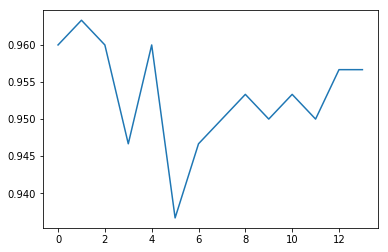

In [95]:
acc=[]
for i in range(len(accuracy)):
    if accuracy[i] > 0:
        acc.append(accuracy[i])

plt.plot(acc)
plt.show()